# 0. Dependencies

In [ ]:
from google.colab import drive # access google drive files (auto-made by selecting "mount drive" in files tab on left)
drive.mount('/content/drive')
# from google.colab import files
import os # accessing/modifying files in drive
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np

import imageio
import datetime
from bisect import bisect_left

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"/content/drive/MyDrive/*Research/Albedo Research/CERES Data/[3.2003-2013 daily cld+alb] CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_20030101-20130131.nc"

'/content/drive/MyDrive/Research/Albedo Research/CERES Data/[3.2003-2013 daily cld+alb] CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_20030101-20130131.nc'

---
# 1. Inputs

In [ ]:
# User note: Edit path and extension as appropriate using file finder tab on the left after mounting drive

root = "/content/drive/MyDrive/*Research/Albedo Research/Hurricane Data/"

allFolders = (
    None,
    "01.Hurricane Sandy (2012.292-314, GOES-13, All bands)",
    "02.Hurricane Ingrid (2013.248-267, GOES-13, All bands)",
    "03.Hurricane Sean (2011.305-322, GOES-13, All bands)",
    "04.Hurricane Irene (2011.226-249, GOES-13, All bands)",
    "05.Hurricane Nicole (2016.271-301, GOES-13, All bands)",
    "06.Hurricane Fabian (2003.232-260, GOES-13, bands 03,08,13,19)",
    "07.Hurricane Karl (2004.253-277, GOES-12, bands 03,08,13,19)",
    "08.Hurricane Bill (2009.220-245, GOES-12, bands 03,08,13,19)",
    "09.Hurricane Danielle (2010.226-249, GOES-13, bands 03,08,13,19)",
    "10.Hurricane Earl (2010.230-255, GOES-13, bands 03,08,13,19)",
    "11.Hurricane Igor (2010.244-273, GOES-13, bands 03,08,13,19)",
    "12.Hurricane Katia (2011.234-261, GOES-13, bands 03,08,13,19)"
)

allBands = [3,8,13]



testFolders = (
    None,
    "01.Hurricane Sandy (2012.292-314, GOES-13, All bands)"
)

testBands = [13]





thresholds = (
    None,
    None,
    None,
    27000,
    27000,
    29000,
    33000,
    31000,
    27000,
    18000,
    19000,
    18000,
    11000,
    10000,
    8000,
    6000,
    7000,
    8000,
    8000,
    10000
)

# Display threshold associated with each band:
for i in range(3,20):
    print("Band " + str(i) + ": " + str(thresholds[i]))

Band 3: 27000
Band 4: 27000
Band 5: 29000
Band 6: 33000
Band 7: 31000
Band 8: 27000
Band 9: 18000
Band 10: 19000
Band 11: 18000
Band 12: 11000
Band 13: 10000
Band 14: 8000
Band 15: 6000
Band 16: 7000
Band 17: 8000
Band 18: 8000
Band 19: 10000


---
# 2. Histogram for One Moment in Time

## 2.1. Helper Functions

In [ ]:
def create_Intervals(max, spacing, limitless):
    '''
    Automatically generate intervals up to `max` with `spacing` between each value. If `limitless`, add a "[max] and above" interval.
    '''
    intervals = []
    this_interval = 0
    while this_interval <= max:
        this_interval += spacing
        intervals.append(this_interval)
    intervals = sorted(intervals)
    if limitless:
        intervals.append(str(this_interval + 1) + "+")
    return intervals



def create_Histogram(filename, intervals):
    '''
    Given a NetCDF file, counts # pixels in each interval
        Note: we're looking at normal array values of float type, we just call them "pixels" because they describe an image
    '''
    # read netCDF file as an array
    file_path = path + "/" + filename
    ds = nc.Dataset(file_path) # ds: "dataset"
    ds.set_auto_mask(False)
    ds = ds["data"][0] # access values with ds[y_index][x_index]

    # loop over all pixels and add to an array if != 0
    pixels = []

    for row in ds: # row of pixels associated with each y index
        for pixel in row: # value of pixel in each row
            if pixel != 0:
                pixels.append(pixel)

    # create and return histogram
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.set_ylim([0, 4000])
    # ax.set_title(filename[filename.index(".")+1:filename.index(".sndr")])
    ax.set_title(filename)
    return plt.hist(pixels, bins = intervals)



def create_Histogram_gif(fn, files, interval):
    '''
    creates a gif @fn.gif of histograms created from @files on @interval
    '''

    filenames = []
    i = 0

    for f in files:
        # interval = create_Intervals(20000, 500, False)
        histogram = create_Histogram(f, interval)

        filename = f'{i}.png'
        i += 1
        filenames.append(filename)

        plt.savefig(filename)
        plt.close()

    with imageio.get_writer(fn + '.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    for filename in set(filenames):
        os.remove(filename)

    return # if errors, try getting rid of this

## 2.2. Usage

In [ ]:
# Inputs
interval = create_Intervals(20000, 500, False)
files = makeFiles("BAND_13.nc")
f = files[16] # Choose a random file

goes13.2012.296.142015.sndr.BAND_13.nc


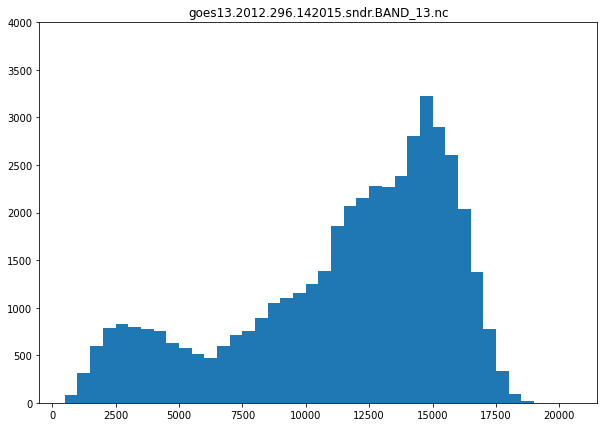

In [ ]:
# Single histogram
print(f)
histogram = create_Histogram(f, interval)

In the above histogram, a lower value (x-axis is measured in satellite counts) corresponds to "thicker" clouds. For Band 13, I've chosen 10,000 as the threshold below which pixels count as cloud. This determination was based on visualizing the data in Panoply.

In [ ]:
# gif of histogram from each file
create_Histogram_gif("temp", files, interval)

---
# 3. GOES


## 3.1. Helper Functions

In [ ]:
def makeFiles(folder, band):
    '''
    Makes a list of chronological file names
    INPUTS:
        folder (string): name of folder with hurricane data
        band (int): number between 1 and 19 corresponding to a GOES band
    OUTPUTS:
        files (list(string)): files in folder in chronological order
    '''
    path = root + folder

    if band < 10:
        extension = "BAND_0" + str(band) + ".nc"
    else:
        extension = "BAND_" + str(band) + ".nc"

    files = []
    for filename in os.listdir(path):
        if filename.endswith(extension):
            #print(filename)
            files.append(filename)
    files = sorted(files)

    return files



def cloudsOverTime(folder, files, threshold):

    time = []
    cloud_ratio = []

    for fn in files:

        # read netCDF file as an array

        file_path = root + folder + "/" + fn
        ds = nc.Dataset(file_path) # ds: "dataset"
        ds.set_auto_mask(False)
        ds = ds["data"][0] # access values with ds[y_index][x_index]

        # calculate ratio of pixels with a value over the threshold to the total number of pixels, add to array

        cloud_pixels = 0
        total_pixels = 0
        #for loop going through each pixel of the file
        for row in ds:
            for pixel in row:
                if pixel != 0:
                    total_pixels += 1
                    if pixel <= threshold:
                        cloud_pixels += 1

        this_ratio = cloud_pixels / total_pixels

        if this_ratio < 0.99:

            cloud_ratio.append(this_ratio)

            # add time value to array

            datetime_utc = float(fn[fn.index(".", 8)+1 : fn.index(".sndr")])
            day = int(datetime_utc)
            time_utc = datetime_utc % 1
            time_decimal = time_utc / 0.245959
            datetime_decimal = day + time_decimal

            time.append(datetime_decimal)


    return (time, cloud_ratio)



# def plot_Threshold(time, cloud_ratio, folder, band, threshold):
def plotCloudsOverTime(folder, band, threshold, time, cloud_ratio, save):
    name = folder[folder.index(".") + 1 :]
    name = name[: name.index(".")] + ")"

    fig, ax = plt.subplots(figsize = (10, 7))
    ax.set_title("Cloud Cover Over Northern Atlantic During " + name + ", as Measured by Band " + str(band) + "\n(Threshold = " + str(threshold) + ")")
    ax.set_xlabel("Day of Year (out of 365)")
    ax.set_ylabel("% North Atlantic Covered")
    ax.set_xlim([min(time), max(time)])
    ax.set_ylim([0, 1])

    plt.plot(time, cloud_ratio);
    plt.savefig(name + " - Band " + str(band) + ".png")
    return
    # return graph



def make_Graph(folder_index, band, save=False):
    folder = folders[folder_index]
    threshold = thresholds[band]

    files = makeFiles(folder, band)
    time, cloud_ratio = cloudsOverTime(folder, files, threshold)
    plotCloudsOverTime(folder, band, threshold, time, cloud_ratio, save)
    return

## 3.2. Usage




In [ ]:
# folder = allFolders
# band = allBands
folders = testFolders
bands = testBands

for folder in range(1, len(folders)):
    print("Now plotting folder " + str(folder))
    for band in bands:
        make_Graph(folder, band, save=True)

Now plotting folder 1


FileNotFoundError: ignored

# 4. CERES + GOES


## 4.1. Naive Graphs

In [ ]:
filePath = "/content/drive/MyDrive/Research/Albedo Research/CERES Data/[1.sandy test] CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_20121001-20121130.nc"

ds = nc.Dataset("/content/drive/MyDrive/Research/Albedo Research/CERES Data/CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_20121001-20121130.nc")
ds.set_auto_mask(False)

FileNotFoundError: ignored

In [ ]:
time = ds["time"][18:40]
dsCloud = ds["cldarea_total_daily"]

cloud_ratio = []

threshold = 65

for i_day in range(18, 40):

    day = dsCloud[i_day]

    cloud_pixels = 0
    total_pixels = 0

    for row in day:
        for pixel in row:
            total_pixels += 1
            if pixel >= threshold:
                cloud_pixels += 1

    cloud_ratio.append(cloud_pixels / total_pixels)


fig, ax = plt.subplots(figsize = (10, 7))
plt.plot(time, cloud_ratio);

NameError: ignored

In [ ]:
time = ds["time"][18:40]
dsCloud = ds["toa_alb_all_daily"]

cloud_ratio = []

threshold = 0.3

for i_day in range(18, 40):

    day = dsCloud[i_day]

    cloud_pixels = 0
    total_pixels = 0

    for row in day:
        for pixel in row:
            total_pixels += 1
            if pixel >= threshold:
                cloud_pixels += 1

    cloud_ratio.append(cloud_pixels / total_pixels)


fig, ax = plt.subplots(figsize = (10, 7))
plt.plot(time, cloud_ratio);

## 4.2. Formalized

### Inputs


In [ ]:
#@title Hurricane to analyze { run: "auto", vertical-output: true, display-mode: "both" }

target_hurricane = 'igor' #@param ["sandy","ingrid","sean","irene","nicole","fabian","karl","bill","danielle","earl","igor","katia"] {allow-input: true}

In [ ]:
##################################################################################
# GOES Data

goesDataRoot = "/content/drive/MyDrive/*Research/Albedo Research/Hurricane Data/"

goesDataFolders = {
    "sandy": "01.Hurricane Sandy (2012.292-314, GOES-13, All bands)",
    "ingrid": "02.Hurricane Ingrid (2013.248-267, GOES-13, All bands)",
    "sean": "03.Hurricane Sean (2011.305-322, GOES-13, All bands)",
    "irene": "04.Hurricane Irene (2011.226-249, GOES-13, All bands)",
    "nicole": "05.Hurricane Nicole (2016.271-301, GOES-13, All bands)",
    "fabian": "06.Hurricane Fabian (2003.232-260, GOES-13, bands 03,08,13,19)",
    "karl": "07.Hurricane Karl (2004.253-277, GOES-12, bands 03,08,13,19)",
    "bill": "08.Hurricane Bill (2009.220-245, GOES-12, bands 03,08,13,19)",
    "danielle": "09.Hurricane Danielle (2010.226-249, GOES-13, bands 03,08,13,19)",
    "earl": "10.Hurricane Earl (2010.230-255, GOES-13, bands 03,08,13,19)",
    "igor": "11.Hurricane Igor (2010.244-273, GOES-13, bands 03,08,13,19)",
    "katia": "12.Hurricane Katia (2011.234-261, GOES-13, bands 03,08,13,19)"
}

bandThresholds = (
    None, None, None, 27000, 27000,
    29000, 33000, 31000, 27000, 18000,
    19000, 18000, 11000, 10000, 8000,
    6000, 7000, 8000, 8000, 10000
)

# # Display threshold associated with each band:
# for i in range(3,20):
#     print("Band " + str(i) + ": " + str(thresholds[i]))

##################################################################################
# CERES Data

# ceresFile = "/content/drive/MyDrive/*Research/Albedo Research/CERES Data/CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_20121001-20121130.nc"

# ceresProducts = {
#     "clouds": {"fullName": "cldarea_total_daily", "threshold": 65},
#     "abledo": {"fullName": "toa_alb_all_daily", "threshold": 0.3}
# }

### GOES

In [ ]:
##################################################################################
# GOES data processing

def Gcldarea_v_time(hurricane, band):

    folder = goesDataFolders[hurricane]
    threshold = bandThresholds[band]

    path = goesDataRoot + folder

    if band < 10:
        extension = "BAND_0" + str(band) + ".nc"
    else:
        extension = "BAND_" + str(band) + ".nc"

    files = []
    for filename in os.listdir(path):
        if filename.endswith(extension):
            # print(filename)
            files.append(filename)
    files = sorted(files)


    time = []
    cloud_ratio = []
    for fn in files:
        # read netCDF file as an array
        file_path = goesDataRoot + folder + "/" + fn
        ds = nc.Dataset(file_path) # ds: "dataset"
        ds.set_auto_mask(False)
        ds = ds["data"][0] # access values with ds[y_index][x_index]

        # calculate ratio of pixels with a value over the threshold to the total number of pixels, add to array
        cloud_pixels = 0
        total_pixels = 0
        for row in ds: # row of pixels associated with each y index
            for pixel in row: # value of pixel in each row
                if pixel != 0:
                    total_pixels += 1
                    if pixel <= threshold: # MODIFIED TO LEQ
                        cloud_pixels += 1
        this_ratio = cloud_pixels / total_pixels

        # add to cloud ratio and time values to array
        if this_ratio < 0.99:
            cloud_ratio.append(this_ratio)

            datetime_utc = float(fn[fn.index(".", 8)+1 : fn.index(".sndr")])
            day = int(datetime_utc)
            time_utc = datetime_utc % 1
            time_decimal = time_utc / 0.245959
            datetime_decimal = day + time_decimal
            time.append(datetime_decimal)

    return (time, cloud_ratio)


# def CERES_v_time(product, time):
#     ds = nc.Dataset(ceresFile)
#     ds.set_auto_mask(False)
#     ds = ds[ ceresVariables[product]["fullName"] ]
#     threshold = ceresVariables[product]["threshold"]

#     start_time


In [ ]:
G_time, G_cldArea = Gcldarea_v_time(target_hurricane, 13)

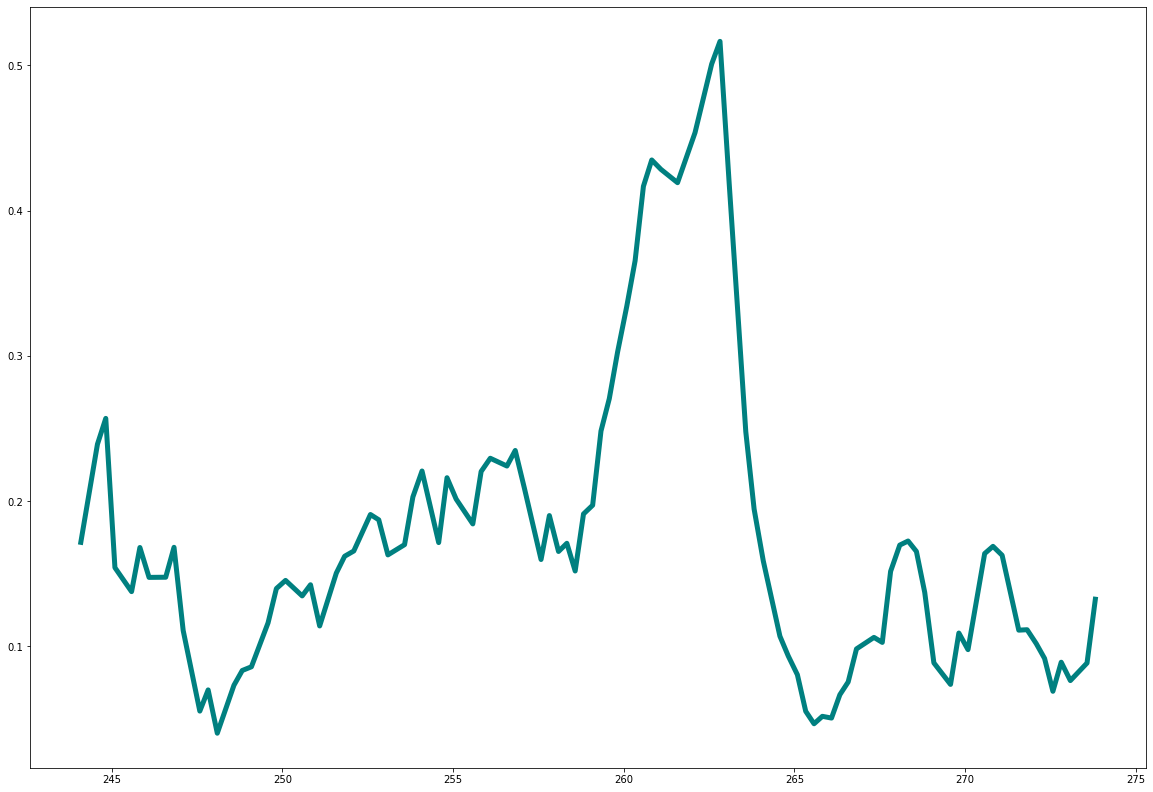

In [ ]:
fig, ax = plt.subplots(figsize = (20, 14))
plt.plot(G_time, G_cldArea, color='teal', linewidth=5);

In [ ]:
# plt.plot(G_time, G_cldArea, 'b');
# plt.plot(C_time, C_cldArea, 'r');

### CERES

In [ ]:
# Import files

# fin = "/content/drive/MyDrive/*Research/Albedo Research/CERES Data/[3.2003-2013 daily cld+alb] CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_20030101-20130131.nc"

fin = '/content/drive/MyDrive/*Research/Albedo Research/CERES Data/important data.nc'

ds = nc.Dataset(fin)
ds.set_auto_mask(False)

In [ ]:
# Calculate time indices

def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

folderName = goesDataFolders[target_hurricane]
hcYear = int(folderName[find_nth(folderName,"(",1)+1 : find_nth(folderName,".",2)]) #finding the hurricane year


hcYear_datetime = datetime.datetime(hcYear, 1, 1)
hcStart_doy = G_time[0]
hcStart_datetime = hcYear_datetime + datetime.timedelta(days = hcStart_doy)
hcEnd_doy = G_time[-1]
hcEnd_datetime = hcYear_datetime + datetime.timedelta(days = hcEnd_doy)

measurementStart = datetime.datetime(2000, 3, 1)

hcStart_daysSince = (hcStart_datetime - measurementStart).days
hcEnd_daysSince = (hcEnd_datetime - measurementStart).days

# hcStart_index = 0
# while ds["time"][hcStart_index] <= hcStart_daysSince:
#     hcStart_index += 1
# hcEnd_index = hcStart_index
# while ds["time"][hcEnd_index] <= hcEnd_daysSince:
#     hcEnd_index += 1

# print(hcStart_index)
# print(hcEnd_index)

def BinarySearch(a, x, epsilon):
    i = bisect_left(a, x)
    if i != len(a) and abs(a[i]-x) <= epsilon:
        return i
    else:
        return -1

epsilon = 1
hcStart_index = BinarySearch(ds["time"], hcStart_daysSince, epsilon)
hcEnd_index = BinarySearch(ds["time"], hcEnd_daysSince, epsilon)


C_time = ds["time"][hcStart_index : hcEnd_index] # raw values, in units "days since measurementStart"
C_time[:] = [t - (hcYear_datetime - measurementStart).days for t in C_time] # put into units of "day of year of [hcYear]"

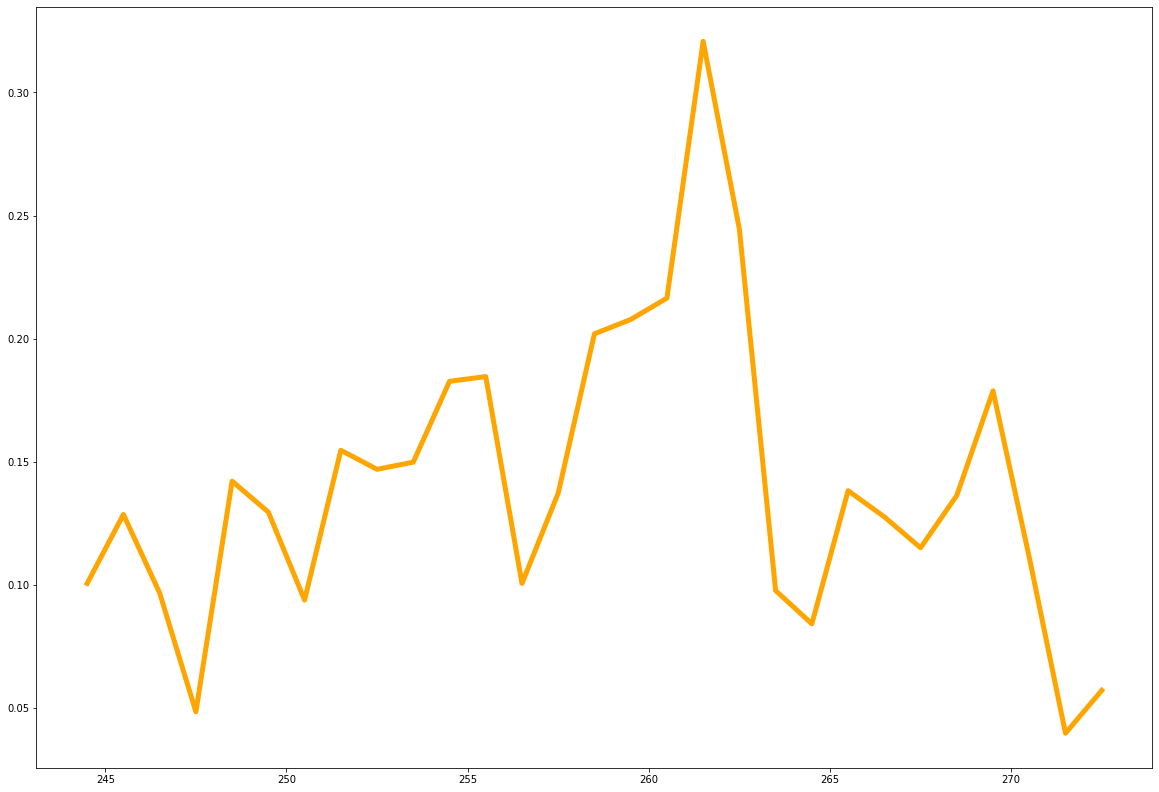

In [ ]:
# Calculate and plot Albedo Cover vs time

C_albArea = [] #################### NOTE TO SELF: compare the albArea and albAvg graphs -- conceptually, does it matter which one we use?
threshold = 0.3

albedoDS = ds["toa_alb_all_daily"][hcStart_index : hcEnd_index]

for frame in albedoDS:

    alb_pixels = 0
    total_pixels = 0

    for row in frame:
        for pixel in row:
            total_pixels += 1
            if pixel >= threshold:
                alb_pixels +=1

    C_albArea.append(alb_pixels / total_pixels)


fig, ax = plt.subplots(figsize = (20, 14))
plt.plot(C_time, C_albArea, color='orange', linewidth=5);

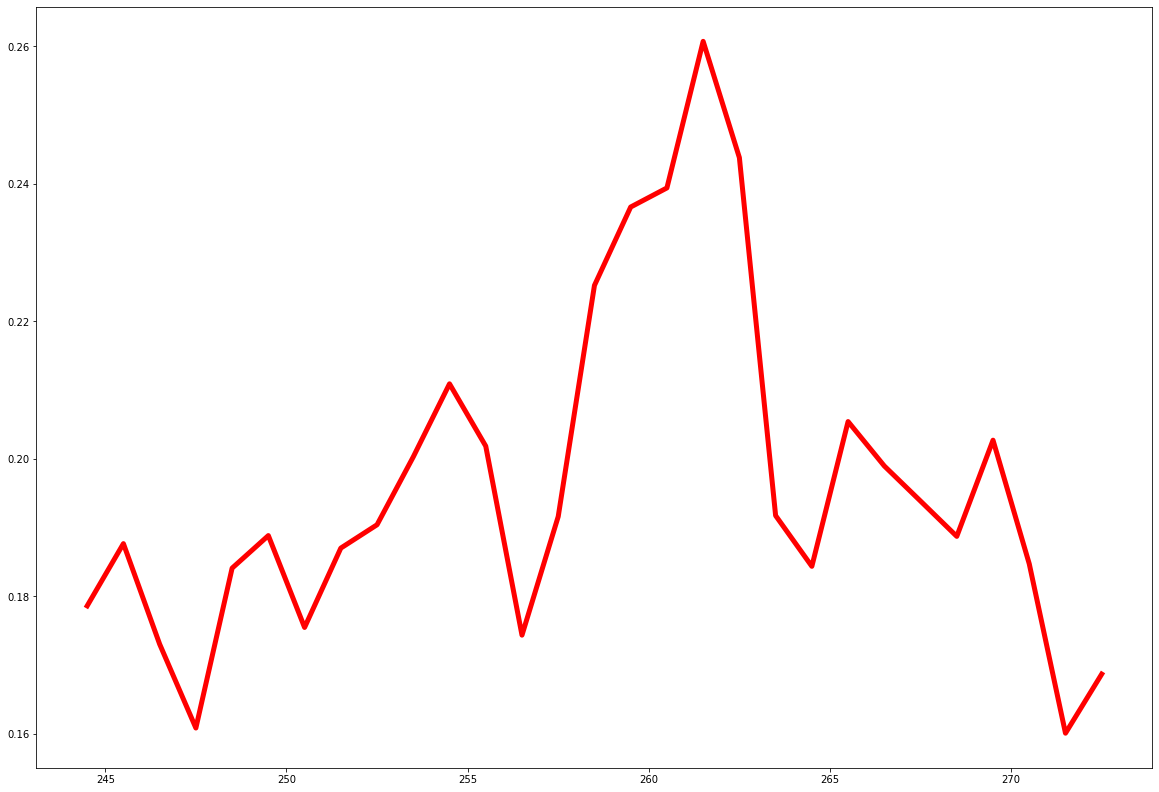

In [ ]:
# Calculate and plot Albedo Average v time

C_albAvg = [] #################### NOTE TO SELF: compare the albArea and albAvg graphs -- conceptually, does it matter which one we use?

albedoDS = ds["toa_alb_all_daily"][hcStart_index : hcEnd_index]

for frame in albedoDS:

    total_albedo = 0
    total_pixels = 0

    for row in frame:
        for pixel in row:
            total_pixels += 1
            total_albedo += pixel

    C_albAvg.append(total_albedo / total_pixels)


fig, ax = plt.subplots(figsize = (20, 14))
plt.plot(C_time, C_albAvg, color='red', linewidth=5);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


Text(0, 0.5, 'Percent Cloud Cover / Percent Solar Radiation Reflected')

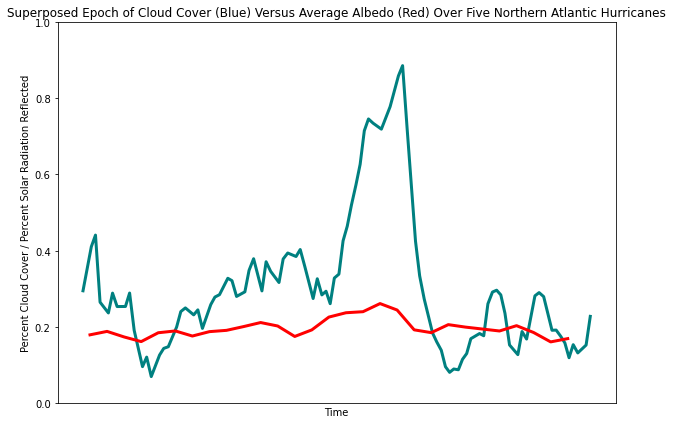

In [ ]:
# Plot everything together

# fig, ax = plt.subplots(figsize = (20, 14))
fig, ax = plt.subplots(figsize = (10, 7))

scale = 1.05
# G_cldArea[:] = [x*scale for x in G_cldArea]
# C_albAvg[:] = [x*scale for x in C_albAvg]



plt.plot(G_time, G_cldArea, 'teal', linewidth=3);
# plt.plot(C_time, C_albArea, 'red');
plt.plot(C_time, C_albAvg, 'red', linewidth=3);
# plt.plot(C_time, C_cldArea, 'b');

ax.set_ylim([0, 1])

ax.set_xticks([], [])
ax.set_title("Superposed Epoch of Cloud Cover (Blue) Versus Average Albedo (Red) Over Five Northern Atlantic Hurricanes")
ax.set_xlabel("Time")
ax.set_ylabel("Percent Cloud Cover / Percent Solar Radiation Reflected")


In [ ]:
# # Calculate and plot Cloud Cover vs time

# C_cldArea = []
# threshold = 70

# cloudDS = ds["cldarea_total_daily"][hcStart_index : hcEnd_index]

# for frame in cloudDS:

#     cld_pixels = 0
#     total_pixels = 0

#     for row in frame:
#         for pixel in row:
#             total_pixels += 1
#             if pixel >= threshold:
#                 cld_pixels +=1

#     C_cldArea.append(cld_pixels / total_pixels)


# fig, ax = plt.subplots(figsize = (10, 7))
# plt.plot(C_time, C_cldArea, 'b');

---
# 3. Misc (delete this)

|Band | Associated cloud threshold|
| --- | ------------------------- |
|03 | 27,000|
|04 | 27,000|
|05 | 29,000|
|06 | 33,000|
|07 | 31,000|
|08 | 27,000|
|09 | 18,000|
|10 | 19,000|
|11 | 18,000|
|12 | 11,000|
|13 | 10,000|
|14 | 8,000|
|15 | 6,000|
|16 | 7,000|
|17 | 8,000|
|18 | 8,000|
|19 | 10,000|

In [ ]:
path = "/content/drive/MyDrive/*Research/Albedo Research/Hurricane Data/01.Hurricane Sandy (2012.292-314, GOES-13, All bands)"
extension = "BAND_09.nc"

files = []
for filename in os.listdir(path):
    if filename.endswith(extension):
        # print(filename)
        files.append(path + "/" + filename)
files = sorted(files)


import xarray as xr


dt = xr.open_mfdataset(files, combine="by_coords", concat_dim="time")

In [ ]:
dt.to_netcdf("combine_band2")